# Computing Lagrangian Statistics

<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#000000; border-left: solid #000000 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Objective: </b> Compute some lagrangian statistics using the file produced with OpenDrift </p>
<p style='margin-left:1em;'>
The lagrangian statistics computed here used the get_statistics.py script and can compute Probability Density Functions, Connectivity Matrices, coefficient of variance, and stranded particles statistics.
</p>
<p style='margin-left:1em;'>
Dec - 2023 | Mireya M. Montano | mireya.mmor@gmail.com
</p>
<p style='margin-bottom:1em; margin-right:1em; text-align:right; font-family:Georgia'>
</p></span>
</div>

### Parameters needed

- file_list (str) List of OpenDrift files to analyse
- outdir (str) path of the directory where to save the output
- id (str) Unique identifier for the experiment. i.e. 'control', 'no_stranding', 'ns' 
- PDF (boolean or arr) If True it calculates the normalised PDF. If true provide the number of bins required [120,90] for the BoP experiments
- CM (boolean) If True it calculates the normalised Connectivity Matrix. (Average if multiple files are provided).
- CV (boolean) If True it calculates the Coefficient of Variation of the Connectivity Matrix. This only works when there are multiple connectivity matrices available.
- stranded (boolean) If True it estimates different values of interest of stranding/beaching of particles.
- time_of_interest (int) Time at which the user wants to calculate all this parameters.
- time_of_interest_units (str) Units of the time of interest defined previously. i.e. 'D' for days, 'H' for hours
- patch (str) If CM is needed the user must provide a file containing the division of regions.


<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#6082B6; border-left: solid #0047AB 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>

- If multiple files are provided the average values of the requested statistics is going to be returned. This is useful if analyses of specific conditions are needed i.e., comparing connectivity in a region under El Nino vs La Nina conditions, a more climatological aspect comparing connectivity in a region under Summer vs Winter conditions 
- The Coefficient of Variation can only be calculated if multiple files are provided as the coefficient of variation is used to quantify the temporal variation in the connectivity matrices.
- To see an example of a patch file please refer to https://github.com/MireyaMMO/Lagrangian_Analyses/blob/main/notebooks/output/Patches_connectivity
</p></span>
</div>

In [1]:
from glob import glob

file_list = sorted(glob("output/200*_Particles_control.nc"))
outdir = "output/stats"
id = "control"
PDF = [120, 90]
CM = True
CV = True
stranded = True
time_of_interest = 7
time_of_interest_units = "D"
patch = "output/Patches_connectivity"

In [2]:
from Lagrangian_Analyses.get_statistics import get_statistics

stats = get_statistics(
    file_list=file_list,
    outdir=outdir,
    id=id,
    PDF=PDF,
    CM=CM,
    CV=CV,
    stranded=stranded,
    time_of_interest=time_of_interest,
    time_of_interest_units=time_of_interest_units,
    patch=patch,
)

stats.run()

INFO:root:--- Creating output directory


--- Analysing output/200301_Particles_control.nc
--- Analysing output/200401_Particles_control.nc
--- Calculating the average of desired variables
--- Saving PDF associated parameters as output/statsPDF_control.p 
 - normalised PDF (n_PDF) 
 - bin edges (xedges, yedges)
--- Saving Connectivity Matrix associated parameters as output/stats/CM_control.p 
 - normalised CM
--- Adding Connectivity Matrix associated parameters to output/stats/CM_control.p 
 - CV
--- Saving stranded particles data associated parameters as output/stats/Stranded_particles_data_control.p 
 - avg_duration 
 - norm_avg_particles_stranded 
 - duration before stranding 
 - stranding coordinates(lon, lat) 
 - origin marker


### Plotting PDF


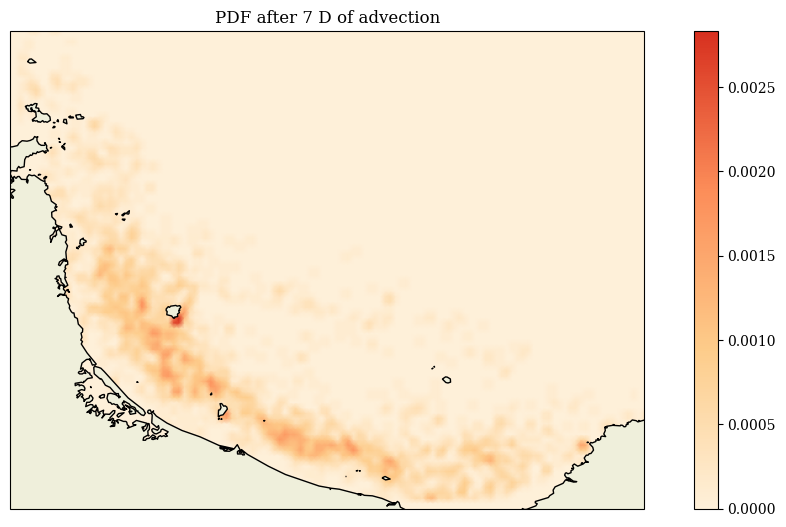

In [3]:
import pickle
from Lagrangian_Analyses.utils import *
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
cmap = get_colourmap("Reds")

fig = plt.figure(figsize=(12.8, 6.2))
nPDF, xedges, yedges = pickle.load(open(f"{outdir}/PDF_{id}.p", "rb"))
projection = ccrs.PlateCarree()
ax = fig.add_subplot(projection=projection)
f = cfeature.GSHHSFeature(scale="high", levels=[1])
ax.add_geometries(
    f.geometries(),
    ccrs.PlateCarree(),
    facecolor=cfeature.COLORS["land"],
    edgecolor="black",
)
c = ax.pcolormesh(
    xedges, yedges, nPDF, transform=projection, cmap=cmap, shading="gouraud"
)
ax.set_title(f"PDF after {time_of_interest} {time_of_interest_units} of advection")
plt.colorbar(c)

### Plotting Connectivity Matrix and coefficient of variance


<div class="warning" style='padding:0.1em; background-color:#FFFFFF; color:#E37383; border-left: solid #9F2B68 4px; border-radius: 4px; padding:0.7em;'>
<span>
<p style='margin-top:1em; text-align:rigth; margin-left:1em'>
<b>Note</b></p>
<p style='margin-left:1em;'>
The last column of the Connectiviy Matrix (sink) refers to the particles that were not located in any of the previously defined regions
</p></span>
</div>

Text(0.5, 1.0, 'Connectivity Matrix after 7 D of advection')

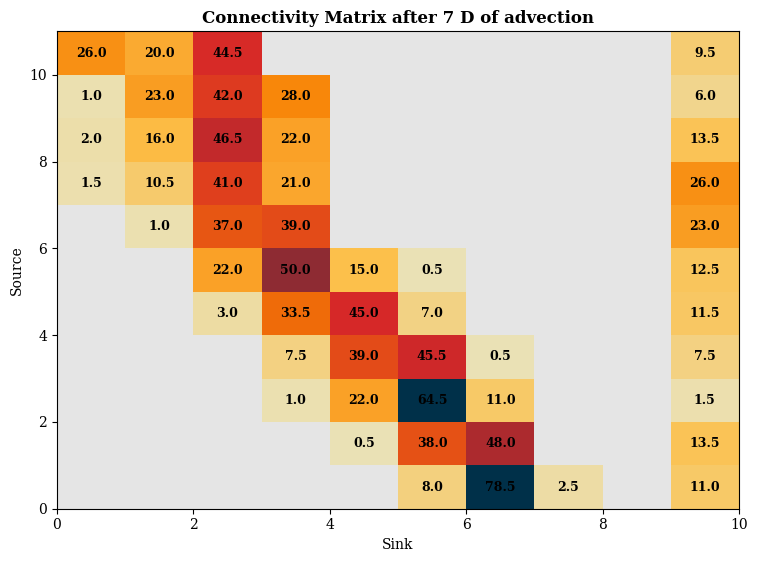

In [4]:
import pickle
from Lagrangian_Analyses.utils import *
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
cmap = get_colourmap("SunOcean")

CM, CV = pickle.load(open(f"{outdir}/CM_{id}.p", "rb"))
X = np.arange(0.5, CM.shape[0] + 0.5, 1)
Y = np.arange(0.5, CM.shape[1] + 0.5, 1)
fig = plt.figure(figsize=(8.8, 6.2))
ax = fig.add_subplot(1, 1, 1)
CM = CM * 100  # percentage
c1 = ax.pcolormesh(Y, X, CM, vmin=0.1, vmax=60, cmap=cmap)
cmap.set_under("gray", 0.2)
for ii in range(len(Y)):
    for jj in range(len(X)):
        if CM[jj, ii] == 0:
            ax.text(
                Y[ii],
                X[jj],
                " ",
                horizontalalignment="center",
                verticalalignment="center",
                weight="bold",
                fontsize=9,
            )
        else:
            ax.text(
                Y[ii],
                X[jj],
                "%.1f" % CM[jj, ii],
                horizontalalignment="center",
                verticalalignment="center",
                weight="bold",
                fontsize=9,
            )

ax.set_ylabel("Source")
ax.set_xlabel(f"Sink")
# ax.invert_yaxis()
ax.set_title(
    f"Connectivity Matrix after {time_of_interest} {time_of_interest_units} of advection",
    weight="bold",
)

Text(0.5, 1.0, 'Coefficient of Variance after 7 D of advection')

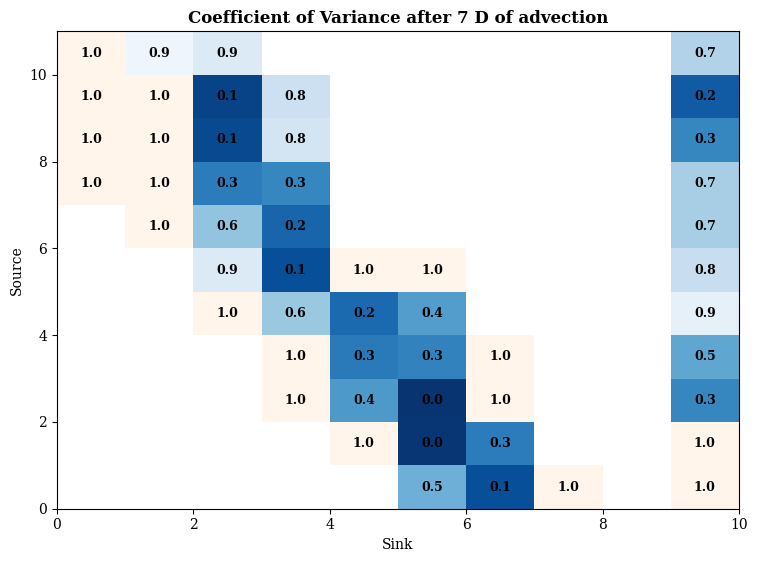

In [5]:
import pickle
from Lagrangian_Analyses.utils import *
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]
cmap = get_colourmap("BlueOrange")
fig = plt.figure(figsize=(8.8, 6.2))
ax = fig.add_subplot(1, 1, 1)
c1 = ax.pcolormesh(Y, X, CV, vmin=0, vmax=2, cmap=cmap)

cmap.set_under("gray", 0.2)
for ii in range(len(Y)):
    for jj in range(len(X)):
        if CV[jj, ii] == 0 or np.isnan(CV[jj, ii]):
            ax.text(
                Y[ii],
                X[jj],
                " ",
                horizontalalignment="center",
                verticalalignment="center",
                weight="bold",
                fontsize=9,
            )
        else:
            ax.text(
                Y[ii],
                X[jj],
                "%.1f" % CV[jj, ii],
                horizontalalignment="center",
                verticalalignment="center",
                weight="bold",
                fontsize=9,
            )

ax.set_ylabel("Source")
ax.set_xlabel(f"Sink")
# ax.invert_yaxis()
ax.set_title(
    f"Coefficient of Variance after {time_of_interest} {time_of_interest_units} of advection",
    weight="bold",
)

### Stranding/Beaching data

In [8]:
(
    avg_duration,
    norm_avg_particles_stranded,
    duration_before_stranding,
    lon_stranding,
    lat_stranding,
    om_stranding,
) = pickle.load(open(f"{outdir}/Stranded_particles_data_{id}.p", "rb"))

In [12]:
from tabulate import tabulate

print(
    tabulate(
        [
            ["Average duration of particles before stranding", f"{avg_duration} hours"],
            [
                "Percentage of stranded particles",
                np.round(norm_avg_particles_stranded * 100, 2),
            ],
        ],
        headers=[
            f"Parameters after {time_of_interest} {time_of_interest_units}",
            "Value",
        ],
    )
)

Parameters after 7 D                            Value
----------------------------------------------  ----------
Average duration of particles before stranding  78.0 hours
Percentage of stranded particles                2.2


With the lon_stranding, lat_stranding and om_stranding parameters it can be identified the percentage of particles stranded from each location if this information is of interest.
This information can complement the connectivity matrix and PDF data